# 注意力汇聚：Nadaraya-Watson 核回归  
查询（自主提示）和键（非自主提示）之间的交互形成了注意力汇聚；  
注意力汇聚有选择地聚合了值（感官输入）以生成最终的输出 
Nadaraya-Watson 核回归来演示具有注意力机制的机器学习

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

根据下面的非线性函数生成一个人工数据集，
其中加入的噪声项为$\epsilon$：

$$y_i = 2\sin(x_i) + x_i^{0.8} + \epsilon,$$

其中$\epsilon$服从均值为$0$和标准差为$0.5$的正态分布。

In [2]:
n_train = 50  # 训练样本数
x_train, _ = torch.sort(torch.rand(n_train) * 5)   # 排序后的训练样本

def f(x):
    return 2 * torch.sin(x) + x**0.8

y_train = f(x_train) + torch.normal(0.0, 0.5, (n_train,))  # 训练样本的输出
x_test = torch.arange(0, 5, 0.1)  # 测试样本
y_truth = f(x_test)  # 测试样本的真实输出
n_test = len(x_test)  # 测试样本数
n_test

50

In [3]:
#绘制训练样本，由圆圈表示  
def plot_kernel_reg(y_hat):
    d2l.plot(x_test, [y_truth, y_hat], 'x', 'y', legend=['Truth', 'Pred'],
             xlim=[0, 5], ylim=[-1, 5])
    d2l.plt.plot(x_train, y_train, 'o', alpha=0.5)

## [**非参数注意力汇聚**]  
根据输入的位置对输出$y_i$进行加权：

$$f(x) = \sum_{i=1}^n \frac{K(x - x_i)}{\sum_{j=1}^n K(x - x_j)} y_i,$$

其中$K$是*核*（kernel）。
公式所描述的估计器被称为
*Nadaraya-Watson核回归*（Nadaraya-Watson kernel regression）。
这里不会深入讨论核函数的细节，
但受此启发，
成为一个更加通用的*注意力汇聚*（attention pooling）公式：

$$f(x) = \sum_{i=1}^n \alpha(x, x_i) y_i,$$

其中$x$是查询，$(x_i, y_i)$是键值对。
注意力汇聚是$y_i$的加权平均。
将查询$x$和键$x_i$之间的关系建模为
*注意力权重*（attention weight）$\alpha(x, x_i)$，
这个权重将被分配给每一个对应值$y_i$。
对于任何查询，模型在所有键值对注意力权重都是一个有效的概率分布。  
如果使用高斯核函数：$$K(u) = \frac{1}{\sqrt{2\pi}} \exp(-\frac{u^2}{2}).$$
$$\begin{aligned} f(x) &=\sum_{i=1}^n \alpha(x, x_i) y_i\\ &= \sum_{i=1}^n \frac{\exp\left(-\frac{1}{2}(x - x_i)^2\right)}{\sum_{j=1}^n \exp\left(-\frac{1}{2}(x - x_j)^2\right)} y_i \\&= \sum_{i=1}^n \mathrm{softmax}\left(-\frac{1}{2}(x - x_i)^2\right) y_i. \end{aligned}$$  
如果一个键$x_i$越是接近给定的查询$x$，
那么分配给这个键对应值$y_i$的注意力权重就会越大，
也就“获得了更多的注意力”

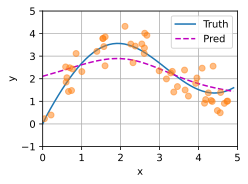

In [4]:
# X_repeat的形状:(n_test,n_train),
# 每一行都包含着相同的测试输入（例如：同样的查询）
X_repeat = x_test.repeat_interleave(n_train).reshape((-1, n_train))
# x_train包含着键。attention_weights的形状：(n_test,n_train),
# 每一行都包含着要在给定的每个查询的值（y_train）之间分配的注意力权重
attention_weights = nn.functional.softmax(-(X_repeat - x_train)**2 / 2, dim=1)
# y_hat的每个元素都是值的加权平均值，其中的权重是注意力权重
y_hat = torch.matmul(attention_weights, y_train)
plot_kernel_reg(y_hat)

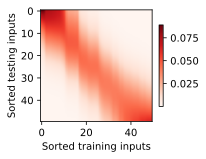

In [5]:
d2l.show_heatmaps(attention_weights.unsqueeze(0).unsqueeze(0),
                  xlabel='Sorted training inputs',
                  ylabel='Sorted testing inputs')
#实验结果也能说明非参数的注意力机制对于两头的数据稍微敏感一些，但是中间比较分散的就没那么在意

## [**带参数注意力汇聚**]

非参数的Nadaraya-Watson核回归具有*一致性*（consistency）的优点：
如果有足够的数据，此模型会收敛到最优结果。
尽管如此，我们还是可以轻松地将可学习的参数集成到注意力汇聚中。
在下面的查询$x$和键$x_i$之间的距离乘以可学习参数$w$：

$$\begin{aligned}f(x) &= \sum_{i=1}^n \alpha(x, x_i) y_i \\&= \sum_{i=1}^n \frac{\exp\left(-\frac{1}{2}((x - x_i)w)^2\right)}{\sum_{j=1}^n \exp\left(-\frac{1}{2}((x - x_j)w)^2\right)} y_i \\&= \sum_{i=1}^n \mathrm{softmax}\left(-\frac{1}{2}((x - x_i)w)^2\right) y_i.\end{aligned}$$
批量的矩阵乘法：**假定两个张量的形状分别是$(n,a,b)$和$(n,b,c)$，
它们的批量矩阵乘法输出的形状为$(n,a,c)$**


In [6]:
X = torch.ones((2, 1, 4))
Y = torch.ones((2, 4, 6))
torch.bmm(X, Y).shape

torch.Size([2, 1, 6])

In [7]:
class NWKernelRegression(nn.Module):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.w = nn.Parameter(torch.rand((1,), requires_grad=True))

    def forward(self, queries, keys, values):
        # queries和attention_weights的形状为(查询个数，“键－值”对个数)
        queries = queries.repeat_interleave(keys.shape[1]).reshape((-1, keys.shape[1]))
        self.attention_weights = nn.functional.softmax(
            -((queries - keys) * self.w)**2 / 2, dim=1)
        # values的形状为(查询个数，“键－值”对个数)
        return torch.bmm(self.attention_weights.unsqueeze(1),
                         values.unsqueeze(-1)).reshape(-1)

In [8]:
# X_tile的形状:(n_train，n_train)，每一行都包含着相同的训练输入
X_tile = x_train.repeat((n_train, 1))
# Y_tile的形状:(n_train，n_train)，每一行都包含着相同的训练输出
Y_tile = y_train.repeat((n_train, 1))
# keys的形状:('n_train'，'n_train'-1)
keys = X_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))
# values的形状:('n_train'，'n_train'-1)
values = Y_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))

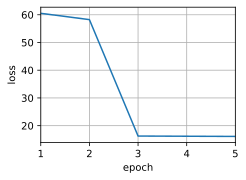

In [9]:
net = NWKernelRegression()
loss = nn.MSELoss(reduction='none')
trainer = torch.optim.SGD(net.parameters(), lr=0.5)
animator = d2l.Animator(xlabel='epoch', ylabel='loss', xlim=[1, 5])

for epoch in range(5):
    trainer.zero_grad()
    l = loss(net(x_train, keys, values), y_train)
    l.sum().backward()
    trainer.step()
    print(f'epoch {epoch + 1}, loss {float(l.sum()):.6f}')
    animator.add(epoch + 1, float(l.sum()))

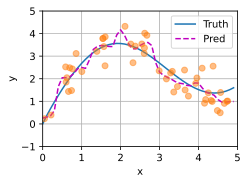

In [10]:
# keys的形状:(n_test，n_train)，每一行包含着相同的训练输入（例如，相同的键）
keys = x_train.repeat((n_test, 1))
# value的形状:(n_test，n_train)
values = y_train.repeat((n_test, 1))
y_hat = net(x_test, keys, values).unsqueeze(1).detach()
plot_kernel_reg(y_hat)

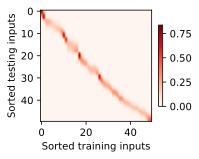

In [11]:
d2l.show_heatmaps(net.attention_weights.unsqueeze(0).unsqueeze(0),
                  xlabel='Sorted training inputs',
                  ylabel='Sorted testing inputs')